**UNSYMMETRIC PENDULUM EXAMPLE**

The example is suggested in \cite{takahashi}. We consider an unsymmetric pendulum, so there will be no symmetries in the solution, with Hamiltonian

$$ H(q,p) = \frac{1}{2} p^2 +U(q) = \frac{1}{2} p^2 - \cos(q) +0.2\sin(2q) $$

and differential equations

$$ \dot q = p, \dot p = -\sin(q) - 0.4\cos(2q) $$

In [1]:
# Import libraries
import numpy as np 
import matplotlib.pyplot as plt
import matplotlib.animation as animation
%matplotlib inline
from IPython.display import HTML
plt.rcParams["figure.figsize"] = (6,4.5) # adjusts plot dimension parameters
plt.rcParams["font.family"] = 'sans-serif'
plt.rcParams["font.sans-serif"] = ['Tahoma'] # changes font

Sample Potential Function: $U(q)$

In [2]:
def U(q):     
    u = -np.cos(q) + 0.2 * np.sin(2*q) 
    return u

In [3]:
def force(q):
    f = -np.sin(q)-0.4*np.cos(2*q)
    d = -np.cos(q)+0.8*np.sin(2*q)
    return f,d

In [5]:
def Verlet(q0, p0, h, force_function):
           
    # p(t+h/2)
    p1 = p0 + h/2 * force_function(q0)[0]
    
    # q(t+h)
    qt = q0 + h*p1

    #p(t+h)
    pt = p1 + h/2 * force_function(qt)[0]
    
    # Compute the new energies
    pe = U(qt)
    ke = np.sum( pt*pt) / 2 
    total_e = ke + pe 
    
    return qt, pt, total_e

In [6]:
def TI_simp(q0, p0, h, force_function):
    
    alpha = 1/12

    # p(n+1/2) = pn + h/2 * f(qn + a*h^2*f(qn))
    p1 = p0 + h/2*force_function(q0 + alpha * h**2 * force_function(q0)[0])[0]
    
    # q(n+1) = qn + h*p(n+1/2)
    qt = q0 + h*p1
    
    #p(n+1) = p(n+1/2) + h/2 * f(q(n+1) + a*h^2*f(q(n+1)))
    pt = p1 + h/2*force_function(qt + alpha * h**2 *force_function(qt)[0])[0]
    
    # Compute the new energies
    ke = np.dot(pt,pt) / 2
    pe = U(qt)
    total_e = ke + pe 
    
    return qt, pt, total_e

In [7]:
def TI(q0, p0, h, force_function):
    
    alpha = 1/12

    # p(n+1/2) = pn + h/2 * f(qn + a*h^2*f(qn))
    p1 = p0 + h/2 * (force_function(q0)[0] + alpha * h**2 * force_function(q0)[1] * force_function(q0)[0])
    
    # q(n+1) = qn + h*p(n+1/2)
    qt = q0 + h*p1
    
    #p(n+1) = p(n+1/2) + h/2 * f(q(n+1) + a*h^2*f(q(n+1)))
    pt = p1 + h/2 * (force_function(qt)[0] + alpha * h**2 * force_function(qt)[1] * force_function(qt)[0])
    
    # Compute the new energies
    ke = np.dot(pt,pt) / 2
    pe = U(qt)
    total_e = ke + pe 
    
    return qt, pt, total_e

In [8]:
def Yoshida(q0, p0, h, force_function):
    # 4th order Yoshida method
    tau0 = 1 / (2 - 2**(1/3))
    tau1 = -2**(1/3) / (2 - 2**(1/3))
    
    q1, p1, _ = Verlet(q0, p0, h*tau0, force_function)
    q2, p2, _ = Verlet(q1, p1, h*tau1, force_function)
    qt, pt, total_e = Verlet(q2, p2, h*tau0, force_function)
    
    return qt, pt, total_e

In [9]:
def run_simulation(q0, p0, Nsteps, h, step_function, force_function):
    
    q_traj = [] 
    p_traj = [] 
    e_traj = [] 
    t_traj = []

    # Set initial conditions
    q = np.copy(q0)
    p = np.copy(p0)
    t = 0

    # Main loop for timestepping
    for n in range(Nsteps):
        
        q,p,energy = step_function(q, p, h, force_function)
        t = t + h 

        q_traj += [q] 
        p_traj += [p] 
        e_traj += [energy] 
        t_traj += [t] 

    q_traj = np.array(q_traj)
    p_traj = np.array(p_traj) 

    return q_traj, p_traj, e_traj, t_traj

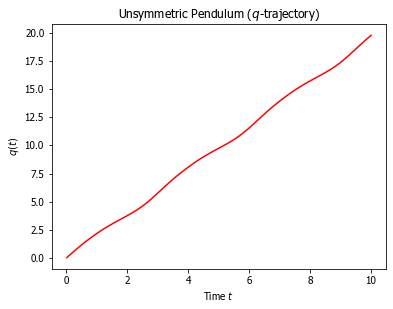

In [10]:
q0 = 0
p0 = 2.5
h = 0.01 # Stepsize
T = 10
Nsteps = 100 # Number of steps
Nsteps = int(T/h)
q_traj, p_traj, e_traj, t_traj = run_simulation( q0,p0, Nsteps, h, Verlet, force)
plt.plot(t_traj, q_traj, 'r')
plt.xlabel('Time $t$')
plt.ylabel('$q(t)$')
plt.title('Unsymmetric Pendulum ($q$-trajectory)')
plt.savefig('unsym_pend_qtraj.png')
plt.show()

In [11]:
T = 100
h = 0.05 # Stepsize
Nsteps = int(T/h) # Number of steps
q_trajV, p_trajV, e_trajV, t_trajV = run_simulation(q0, p0, Nsteps, h, Verlet, force)
q_trajTI, p_trajTI, e_trajTI, t_trajTI = run_simulation(q0, p0, Nsteps, h, TI, force)
q_trajSTI, p_trajSTI, e_trajSTI, t_trajSTI = run_simulation(q0, p0, Nsteps, h, TI_simp, force)
q_trajY, p_trajY, e_trajY, t_trajY = run_simulation(q0, p0, Nsteps, h, Yoshida, force)

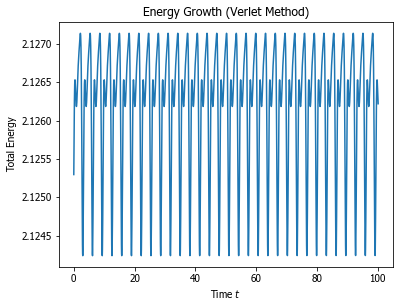

In [13]:
plt.plot(t_trajV, e_trajV, color = 'tab:blue')
plt.xlabel('Time $t$')
plt.ylabel('Total Energy')
plt.title('Energy Growth (Verlet Method)')
plt.savefig('EG-2a.png')
plt.show()

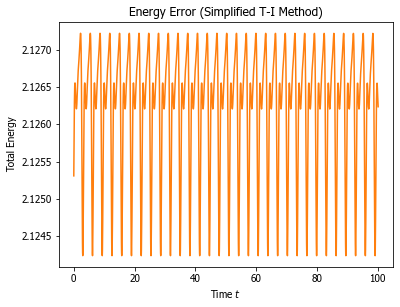

In [14]:
plt.plot(t_trajSTI, e_trajSTI, color = 'tab:orange')
plt.xlabel('Time $t$')
plt.ylabel('Total Energy')
plt.title('Energy Error (Simplified T-I Method)')
plt.savefig('EG-2b.png')
plt.show()

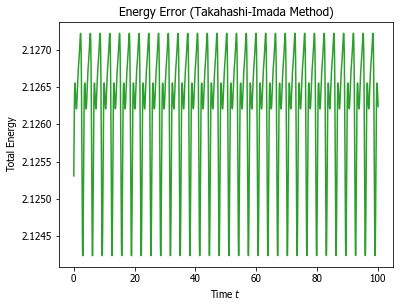

In [15]:
plt.plot(t_trajTI, e_trajTI, color = 'tab:green')
plt.xlabel('Time $t$')
plt.ylabel('Total Energy')
plt.title('Energy Error (Takahashi-Imada Method)')
plt.savefig('EG-2c.png')
plt.show()

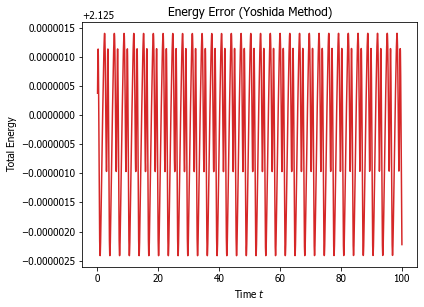

In [16]:
plt.plot(t_trajY, e_trajY, color = 'tab:red')
plt.xlabel('Time $t$')
plt.ylabel('Total Energy')
plt.title('Energy Error (Yoshida Method)')
plt.savefig('EG-2d.png')
plt.show()

In [17]:
def Find_Traj(h,T,step_function,force_function):
    '''
    This function takes step size and time as input and using Euler's method it returns 
    corresponding trajectory arrays for q and p.
    '''

    Nsteps = int(T / h)

    # Make a copy of our initial values so we
    # don't accidently overwrite them 
    q = np.copy(q0)
    p = np.copy(p0)
    t = 0 #t0

    # Initialize our saved trajectory to be blank 
    q_traj = [] 
    p_traj = [] 
    t_traj = [] 
    e_traj = [] 

    # Run the loop 
    for n in range(Nsteps):
        t = t + h
        q,p,energy = step_function(q, p, h, force_function)

        q_traj = q_traj + [q] 
        p_traj = p_traj + [p]
        t_traj = t_traj + [t] 
        e_traj = e_traj + [energy] 

    # Make these into numpy arrays
    q_traj = np.array(q_traj)
    p_traj = np.array(p_traj)
    
    return q_traj,p_traj

def total_energy(q,p):
    pe = U(q)
    ke =  np.dot(p,p) / 2
    e = pe + ke
    return e
    
def Find_MaxDif(q_traj,p_traj,h,T):
    '''
    This function takes trajectory arrays, step size and time and returns the maximum energy difference
    of the arrays (a scalar).
    '''
    Nsteps = int(T / h)
    energydifvec = np.zeros(Nsteps)
    
    for i in range(Nsteps):
        energydifvec[i] = abs(total_energy(q0,p0)-total_energy(q_traj[i],p_traj[i]))
        
    return max(energydifvec)

In [18]:
q0 = 0
p0 = 2.5
T = 10
h = np.arange(0.001,0.1,0.001)
h_len = len(h)
maxvecSE = np.zeros(h_len)
maxvecV = np.zeros(h_len)
maxvecSTI = np.zeros(h_len)
maxvecTI = np.zeros(h_len)
maxvecY = np.zeros(h_len)

# loop over stepsizes h
for i in range(h_len):
    # saving the trajectory arrays corresponding to a particular step size into new variables
    q_trajSE,p_trajSE = Find_Traj(h[i],T,sympl_Euler,force)
    q_trajV,p_trajV = Find_Traj(h[i],T,Verlet,force)
    q_trajSTI,p_trajSTI = Find_Traj(h[i],T,TI_simp,force)
    q_trajTI,p_trajTI = Find_Traj(h[i],T,TI,force)
    q_trajY,p_trajY = Find_Traj(h[i],T,Yoshida,force)

    # saving the maximum value for each h in the vector of max energy differences
    maxvecSE[i] = Find_MaxDif(q_trajSE,p_trajSE,h[i],T)
    maxvecV[i] = Find_MaxDif(q_trajV,p_trajV,h[i],T)
    maxvecSTI[i] = Find_MaxDif(q_trajSTI,p_trajSTI,h[i],T)
    maxvecTI[i] = Find_MaxDif(q_trajTI,p_trajTI,h[i],T)
    maxvecY[i] = Find_MaxDif(q_trajY,p_trajY,h[i],T)

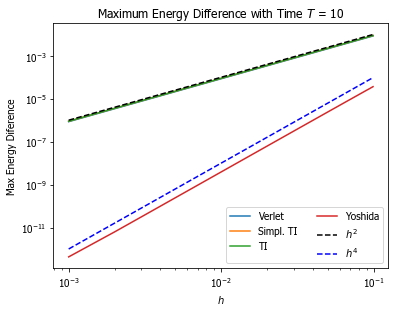

In [19]:
plt.loglog(h,maxvecV,label="Verlet")
plt.loglog(h,maxvecSTI,label="Simpl. TI")
plt.loglog(h,maxvecTI,label="TI")
plt.loglog(h,maxvecY,label="Yoshida")
plt.loglog(h,h**2,'--k',label="$h^2$")
plt.loglog(h,h**4,'--b',label="$h^4$")

plt.xlabel('$h$')
plt.ylabel('Max Energy Diference') 
plt.title('Maximum Energy Difference with Time $T$ = 10')
plt.legend(ncol = 2)
plt.savefig('unsym_pend_all.png')
plt.show()

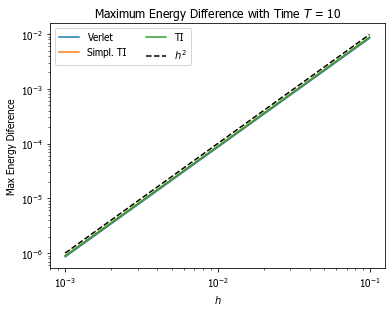

In [20]:
plt.plot(h,maxvecV,label="Verlet", color = 'tab:blue')
plt.plot(h,maxvecSTI,label="Simpl. TI", color = 'tab:orange')
plt.plot(h,maxvecTI,label="TI", color = 'tab:green')
plt.loglog(h,h**2,'--k',label="$h^2$")

plt.xlabel('$h$')
plt.ylabel('Max Energy Diference') 
plt.title('Maximum Energy Difference with Time $T$ = 10')
plt.legend(ncol = 2)
plt.savefig('unsym_pend_order2.png')
plt.show()